In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
import matplotlib.pyplot as plt

IMDB dataset:

plain text reviews

byte encoded text

integer encoded test 8k vocubulary

integer encoded text 32k vocablary

In [ ]:
data, meta = tfds.load('imdb_reviews/subwords8k',
                       with_info=True,
                       as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteU6EIFC/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteU6EIFC/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteU6EIFC/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [ ]:
data.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [ ]:
train = data['train']
test = data['test']
train, test

(<PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>,
 <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>)

In [ ]:
#prepare an encoder, decoder
meta.features

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
})

In [ ]:
#extract the encoder
encoder = meta.features['text'].encoder

In [ ]:
encoder.vocab_size

8185

In [ ]:
print(encoder.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [ ]:
example = "My name is Nikhil Garg !"
enc = encoder.encode(example)
enc

[387, 769, 9, 1596, 3387, 2585, 1472, 8032, 5219]

In [ ]:
for integer in enc:
  text = encoder.decode([integer])
  print('%4d : %s' %(integer, text))

 387 : My 
 769 : name 
   9 : is 
1596 : Ni
3387 : kh
2585 : il 
1472 : Gar
8032 : g
5219 :  !


input text: not of fixed length
fix the length of each input token

In [ ]:
BUFFER_SIZE=10000
BATCH_SIZE=64
AUTOTUNE = tf.data.AUTOTUNE
train_data = train.shuffle(BUFFER_SIZE)
train_data = train_data.padded_batch(BATCH_SIZE, padded_shapes=([None], []))
train_data = train_data.prefetch(AUTOTUNE)

test_data = test.padded_batch(BATCH_SIZE, padded_shapes=([None], []))
embed_layer = keras.layers.Embedding(encoder.vocab_size, 64)

In [ ]:
model  = keras.Sequential([
                           #embedding layer
                           embed_layer,
                           #bidirectional layers
                           Bidirectional(LSTM(64,
                                              dropout=0.5,
                                              recurrent_dropout=0.5,
                                              return_sequences=True)),
                           Bidirectional(LSTM(32,
                                              dropout=0.5,
                                              recurrent_dropout=0.5,
                                              return_sequences=True)),
                           Bidirectional(LSTM(16,
                                              dropout=0.5,
                                              recurrent_dropout=0.5)),
                           #fully connected layer or dense layer
                           Dense(64, activation='relu', kernel_regularizer='l2'),
                           Dropout(0.5),
                           Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 64)         41216     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                        

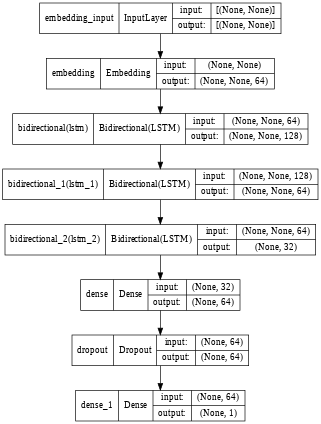

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data,
                    validation_data=test_data,
                    epochs=2)

Epoch 1/2
267/391 [===================>..........] - ETA: 27:37 - loss: 0.7856 - accuracy: 0.5880

In [ ]:
hist = history.history
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(labels=['Training', 'Validation'])
plt.xlabel(['Epochs'])
plt.ylabel(['Loss'])
plt.show()